In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
# The input file is read and it is splitted into X and Y:

train_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_data  = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
Y = train_data["SalePrice"]
X = train_data.drop(["SalePrice","Id"], axis=1)
IdTest = test_data.Id
test_data = test_data.drop("Id", axis = 1)

print (X.shape)
print (test_data.shape)
#print (train_data.iloc[:,6])

(1460, 79)
(1459, 79)


In [3]:
# All the columns of the original dataset were analysed and the following conclusions were drawn:

# For some columns we just dont have enough data so as the model could learn what each categorical possibility means in terms of price. For example the neighborhood. This kind of categorical features that are splitted into several columns just add noise to the data if you dont have enough examples.
X         = X.drop        (["Neighborhood","Exterior1st","Exterior2nd","GarageType","Condition1","Condition2"], axis =1)
test_data = test_data.drop(["Neighborhood","Exterior1st","Exterior2nd","GarageType","Condition1","Condition2"], axis =1)

# For MSSubClass, there is no point in treating the categories as numbers, given that a bigger or smaller number doesn't mean more or less value:
X["MSSubClass"]          = X["MSSubClass"].astype(str)
test_data ["MSSubClass"] = test_data["MSSubClass"].astype(str)

# Other columns express the quality of some part of the house. That should not be included in the get_dummies function.
# It would be desirable to transform the scale from Excellent to Poor into a numerical scale, such as from 5 to 1.
fromStringToInt = {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1,np.nan:0}
qualityColumns = ["ExterQual","ExterCond","BsmtQual","BsmtCond","HeatingQC","KitchenQual","FireplaceQu","GarageQual","GarageCond","PoolQC"]
for column in qualityColumns:
    X[column].replace(fromStringToInt, inplace=True)
    test_data[column].replace(fromStringToInt, inplace=True)

In [4]:
# Some of the columns need a specific dictionary to convert from String to Categorical Quality Numbers:
fromStringToIntLotShape = {"Reg":4,"IR1":3,"IR2":2,"IR3":1,np.nan:0}
X["LotShape"].replace(fromStringToIntLotShape, inplace=True)
test_data["LotShape"].replace(fromStringToIntLotShape, inplace=True)

fromStringToIntUtilities = {"AllPub":4,"NoSewr":3,"NoSeWa":2,"ELO":1,np.nan:0}
X["Utilities"].replace(fromStringToIntUtilities, inplace=True)
test_data["Utilities"].replace(fromStringToIntUtilities, inplace=True)

fromStringToIntLandSlope = {"Gtl":3,"Mod":2,"Sev":1,np.nan:0}
X["LandSlope"].replace(fromStringToIntLandSlope, inplace=True)
test_data["LandSlope"].replace(fromStringToIntLandSlope, inplace=True)

fromStringToIntBsmtFinType = {"GLQ":6,"ALQ":5,"BLQ":4,"Rec":3,"LwQ":2,"Unf":1,np.nan:0}
X["BsmtFinType1"].replace(fromStringToIntBsmtFinType, inplace=True)
test_data["BsmtFinType1"].replace(fromStringToIntBsmtFinType, inplace=True)
X["BsmtFinType2"].replace(fromStringToIntBsmtFinType, inplace=True)
test_data["BsmtFinType2"].replace(fromStringToIntBsmtFinType, inplace=True)

fromStringToIntFunctional = {"Typ":8,"Min1":7,"Min2":6,"Mod":5,"Maj1":4,"Maj2":3,"Sev":2,"Sal":1,np.nan:0}
X["Functional"].replace(fromStringToIntFunctional, inplace=True)
test_data["Functional"].replace(fromStringToIntFunctional, inplace=True)

fromStringToIntGarageFinish = {"Fin":3,"RFn":2,"Unf":1,np.nan:0}
X["GarageFinish"].replace(fromStringToIntGarageFinish, inplace=True)
test_data["GarageFinish"].replace(fromStringToIntGarageFinish, inplace=True)

fromStringToIntPavedDrive = {"Y":3,"P":2,"N":1,np.nan:0}
X["PavedDrive"].replace(fromStringToIntPavedDrive, inplace=True)
test_data["PavedDrive"].replace(fromStringToIntPavedDrive, inplace=True)

fromStringToIntFence = {"GdPrv":4,"MnPrv":3,"GdWo":2,"MnWw":1,np.nan:0}
X["Fence"].replace(fromStringToIntFence, inplace=True)
test_data["Fence"].replace(fromStringToIntFence, inplace=True)

In [5]:
print (X.shape)
print (test_data.shape)  

(1460, 73)
(1459, 73)


In [6]:
# Before splitting categorical variables, let's get only the numerical columns and check which ones are skewed:
nameOfNumericColumns = X.dtypes[X.dtypes!="object"].index
skewedVariables = X[nameOfNumericColumns].skew()
for index, value in enumerate (skewedVariables):
    if (value > 1):
        X[nameOfNumericColumns[index]]         = np.log (X[nameOfNumericColumns[index]]+0.001)
        test_data[nameOfNumericColumns[index]] = np.log (test_data[nameOfNumericColumns[index]]+0.001)

In [7]:
# All the columns with a greater percentage than desired of NaNs are dropped since they will not generalise well:

percentageMissingValuesPerColumn = (len(X)-X.count())/len(X)*100
maxPercentageDesired = 0.05 # 5%
falseTrueColumns = percentageMissingValuesPerColumn>maxPercentageDesired
columnIndexesToBeDropped = []
for i in range (X.shape[1]):
    if (falseTrueColumns[i]): # True means that column has more percentage of NaNs than desired
        columnIndexesToBeDropped.append(i)
print (X.shape)
X_clean = X.drop(X.columns[columnIndexesToBeDropped], axis=1)
test_data_clean = test_data.drop(test_data.columns[columnIndexesToBeDropped], axis=1)
allData = pd.concat([X_clean, test_data_clean])
print (allData.shape)
allData_clean = pd.get_dummies(allData)
print (allData_clean.shape)

(1460, 73)
(2919, 65)
(2919, 139)


In [8]:
variancePerColumn  = allData_clean.var( axis=0)
maximumPerColumn   = allData_clean.max( axis=0)

columnsWorthKeeping = []

for i in range (len (variancePerColumn)):
     if ((variancePerColumn[i]/maximumPerColumn[i])> 0.01):
        columnsWorthKeeping.append(i)
allData_clean = allData_clean.iloc[:,columnsWorthKeeping]
print (allData_clean.shape)

(2919, 97)


In [9]:
mean = np.mean (allData_clean)
#print (mean.shape)
allData_clean = np.array(allData_clean.values)


for i in range (allData_clean.shape[0]):
    for j in range (allData_clean.shape[1]):
        if (np.isnan(allData_clean[i][j])):
            allData_clean[i][j] = mean[j]

X_clean = allData_clean[:1460]
test_data_clean = allData_clean[1460:]

print (X_clean.shape)
print (test_data_clean.shape)


(1460, 97)
(1459, 97)


In [10]:
# Split the X_clean data into train and validation sets. There are 1460 examples so 1200 / 260 seems reasonable:
random_list = np.random.permutation(1460)
cuttingNumber = 1200

X_clean = np.array(X_clean)
X_train = X_clean [random_list[:cuttingNumber]]
Y_train = Y       [random_list[:cuttingNumber]]
X_val   = X_clean [random_list[cuttingNumber:]]
Y_val   = Y       [random_list[cuttingNumber:]]
test_data_clean = np.array(test_data_clean)

print (X_clean.shape)
print (Y.shape)
print (test_data_clean.shape)
print (IdTest.shape)

(1460, 97)
(1460,)
(1459, 97)
(1459,)


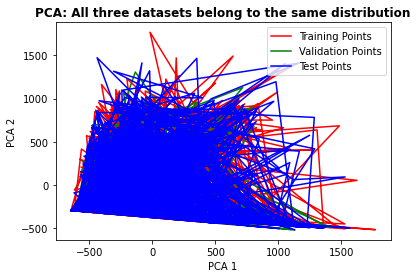

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA (n_components=2)
concat = np.concatenate((X_train,X_val,test_data_clean),axis=0)

pca.fit(concat)
trainPoints = pca.transform(X_train)
valPoints = pca.transform(X_val)
testPoints = pca.transform (test_data_clean)

plt.plot(trainPoints[:,0], trainPoints[:,1], c="red")
valPoints = pca.transform(X_val)
plt.plot(valPoints[:,0], valPoints[:,1], c="green")

plt.plot(testPoints[:,0], testPoints[:,1], c="blue")
plt.title ("PCA: All three datasets belong to the same distribution", fontweight="bold")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(["Training Points","Validation Points","Test Points"])
plt.show()

In [12]:
import tensorflow as tf
from tensorflow import keras
def rmsle_error(y_true, y_pred): 
    return tf.math.sqrt(keras.losses.MSLE(y_true, y_pred))

In [13]:
# Sometimes the model gets stuck because of a local optima. Other times the gradients exploit. So we have to restart it
initialLoss = 100
finalLoss = np.nan
while (initialLoss > 8 or (not finalLoss > 0)):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=100, activation = "relu", input_shape = [X_train.shape[1],],kernel_initializer=keras.initializers.GlorotNormal()))
    model.add(keras.layers.Dense(units=75, activation = "relu",kernel_initializer=keras.initializers.GlorotNormal()))
    model.add(keras.layers.Dense(units=50, activation = "relu",kernel_initializer=keras.initializers.GlorotNormal()))
    model.add(keras.layers.Dense(units=25, activation = "relu",kernel_initializer=keras.initializers.GlorotNormal()))
    model.add(keras.layers.Dense(units=15, activation = "relu",kernel_initializer=keras.initializers.GlorotNormal()))
    model.add(keras.layers.Dense(units=1,  activation = "relu",kernel_initializer=keras.initializers.GlorotNormal))
    model.compile(optimizer = keras.optimizers.Adam(lr=0.0003), loss = rmsle_error)
    history = model.fit (X_train, Y_train, batch_size=16, epochs = 400, verbose=1, validation_data = (X_val,Y_val))
    initialLoss = history.history["loss"][0]
    finalLoss = history.history["loss"][-1]
    print (model.evaluate(X_val, Y_val))

Train on 1200 samples, validate on 260 samples
Epoch 1/400
1200/1200 [==============================] - 1s 747us/sample - loss: 5.5763 - val_loss: 4.3880
Epoch 2/400
1200/1200 [==============================] - 0s 152us/sample - loss: 3.6270 - val_loss: 2.9255
Epoch 3/400
1200/1200 [==============================] - 0s 153us/sample - loss: 2.3212 - val_loss: 1.7330
Epoch 4/400
1200/1200 [==============================] - 0s 150us/sample - loss: 1.1885 - val_loss: 0.6845
Epoch 5/400
1200/1200 [==============================] - 0s 152us/sample - loss: 0.4040 - val_loss: 0.2722
Epoch 6/400
1200/1200 [==============================] - 0s 154us/sample - loss: 0.2660 - val_loss: 0.2705
Epoch 7/400
1200/1200 [==============================] - 0s 157us/sample - loss: 0.2649 - val_loss: 0.2690
Epoch 8/400
1200/1200 [==============================] - 0s 152us/sample - loss: 0.2636 - val_loss: 0.2675
Epoch 9/400
1200/1200 [==============================] - 0s 152us/sample - loss: 0.2620 - val_los

In [14]:
predictions = np.squeeze(model.predict(test_data_clean), axis=1)
output = pd.DataFrame({'Id':IdTest,'SalePrice':predictions})
output.to_csv("my_submission.csv", index=False)
print ("Your submission was succesfully saved!")

Your submission was succesfully saved!
